# Yoochoose Contest
#### Dan Finkel
#### March 26 2018

From the instructions:
> Take a look at ​http://recsys.yoochoose.net/challenge.html​. The goal of part 1 of the task is to predict whether a user on a typical e-commerce site will buy an item. Ignore part 2, predicting which items are purchased. There is a dataset provided; download it. You can Ignore the “yoochoose-test.dat” file, as that was used for the challenge submission, which is no longer active.

> Tell us a story about these data. Use any tools you wish: Python, R, etc. The dataset is a good size but should be manageable on a modern personal computer. If you have any trouble with the size, work with a sample.

> You can submit results in any format you like. If you use Python or R, a Jupyter notebook is ideal. Don’t submit any data back to us. Also note there are two pages in this document; there are ten questions in section 2; don’t miss the questions on page 2.

Thanks for all of the guidance. My approach to this exercise will be to
1. Read, understand, manipulate and visualize the data
2. Engineer features (as needed)
3. Build a prediction model and measure performance

I will circle back to the questions as we go through the process

*Note: In keeping with the stated objective of this exercise, I decided not to look at the solution link for this exercise. Instead I am going to focus on exploring and building an understanding of the problem*

In [1]:
# Imports and Set-up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random

# allows for inline plotting
%matplotlib inline

# pretty plots
plt.style.use("bmh")

# better sizing for the notebook
plt.rcParams['figure.figsize'] = (10, 5)

## Step 1: Read, understand, manipulate and visualize the data
A few key notes from the instructions

>The training data comprises two different files: yoochoose-clicks.dat and yoochoose-buys.dat

>1. yoochoose-clicks.dat - Click events. Each record/line in the file has the following fields:
    1. Session ID – the id of the session. In one session there are one or many clicks.
    2. Timestamp – the time when the click occurred.
    3. Item ID – the unique identifier of the item.  
    4. Category – the category of the item.

>2. yoochoose-buys.dat - Buy events. Each record/line in the file has the following fields:
    1. Session ID - the id of the session. In one session there are one or many buying events.
    2. Timestamp - the time when the buy occurred.
    3. Item ID – the unique identifier of item.
    4. Price – the price of the item.
    5. Quantity – how many of this item were bought.

Lastly, a good note to remember:
> The Session ID in yoochoose-buys.dat will always exist in the yoochoose-clicks.dat file – the records with the same Session ID together form the sequence of click events of a certain user during the session. The session could be short (few minutes) or very long (few hours), it could have one click or hundreds of clicks. All depends on the activity of the user.

To start, read the data:

In [2]:
# Read the data
df_clicks = pd.read_csv(
    '/Users/dfinkel/proto_dev/data_science/yoochoose/yoochoose-data/yoochoose-clicks.dat',
    header=None)

# per instructions there are 4 fields on the click data
#     Session ID – the id of the session. In one session there are one or many clicks.
#     Timestamp – the time when the click occurred.
#     Item ID – the unique identifier of the item.
#     Category – the category of the item.
df_clicks.columns = ('sessionID', 'timestamp', 'itemID', 'category')

df_buys = pd.read_csv(
    '/Users/dfinkel/proto_dev/data_science/yoochoose/yoochoose-data/yoochoose-buys.dat',
    header=None)

# per instructions there are 5 fields on the buy data
#     Session ID - the id of the session. In one session there are one or many buying events.
#     Timestamp - the time when the buy occurred.
#     Item ID – the unique identifier of item.
#     Price – the price of the item.
#     Quantity – how many of this item were bought.
df_buys.columns = ('sessionID', 'timestamp', 'itemID', 'price', 'Quantity')

# Goin through data I noticed there
# "duplicates" in the buy data (i.e., same
# session, item and quantity). Going to drop 
# them here - TODO would be also add a time
# filter and make sure they aren't different
# purchase events
df_buys = df_buys.drop_duplicates(['sessionID', 'itemID', 'Quantity'])

/Users/dfinkel/siphonenv/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Next, take a look at the data

In [3]:
# show data
df_clicks.head()

,sessionID,timestamp,itemID,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


In [4]:
# show data
df_buys.head()

,sessionID,timestamp,itemID,price,Quantity
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1


The first question asked is:
> - What is the high-level shape of the data? How many sessions are there? How many result in a purchase? Is that important?

A good question that fits well with our stated objective to read and understand the data.

In [5]:
# determine click and buy session counts
click_sessions_ct = len(df_clicks['sessionID'].unique())
buy_sessions_ct = len(df_buys['sessionID'].unique())

# print stats
print 'There are %i unique click sessions in our training set\
and %i of them have a purchase in them, or %.2f percent' \
        % (click_sessions_ct, buy_sessions_ct,
           100.*buy_sessions_ct / (buy_sessions_ct + click_sessions_ct))

There are 9249729 unique click sessions in our training setand 509696 of them have a purchase in them, or 5.22 percent


So 5.22% of sessions result in purchase. That is interesting. I think it's important because we can use it to create labels for sessions. Since we need to predict item purchases in Part 2, let's also go ahead and label the item purchases too.

**NOTE**: During my first pass I was having cpu trouble engineering features with the full data set. So, I chose to downsample the data for this exercise. I'll be sure to mention this in submission email.

In [6]:
# create labels if session results in a purchase
buy_sessionIDs = df_buys['sessionID'].values
df_clicks['session_purchase'] = np.where(df_clicks['sessionID'].isin(buy_sessionIDs), 1, 0)

# create labels if item is purchased
# a little tricky because join is on
# session and itemID
# Create an index so we can join at the end
df_clicks['idx'] = np.arange(len(df_clicks))

# merge clicks and busy on session and item
df_merge = pd.merge(df_clicks, df_buys, how='inner',
                   left_on = ['sessionID', 'itemID'],
                   right_on = ['sessionID', 'itemID'])

# label these rows as purchased
df_merge['item_purchase'] = 1

# outer join them back into df_clicks
df_clicks_aug = df_clicks.merge(right=df_merge, how='outer', left_on='idx', right_on='idx')

# fill in the relevant nans in with a 0
df_clicks_aug['item_purchase'] = df_clicks_aug['item_purchase'].fillna(0)
df_clicks_aug['price'] = df_clicks_aug['price'].fillna(0)
df_clicks_aug['Quantity'] = df_clicks_aug['Quantity'].fillna(0)

# remove un-needed columns 
# created by the joins
df_clicks_aug = df_clicks_aug[[
                    'sessionID_x',
                    'timestamp',
                    'itemID_x',
                    'category_x',
                    'session_purchase_x',
                    'price',
                    'Quantity',
                    'item_purchase']]

# rename columns distorted by the joins
df_clicks_aug.columns = ['sessionID',
                         'timestamp',
                         'itemID',
                         'category',
                         'session_purchase',
                         'price',
                         'quantity',
                         'item_purchase']

# For exploration purposes choose a
# subset of the data to work with
sessions = df_clicks['sessionID'].unique()
sessions_sub = random.sample(sessions, 1000000)
df_clicks_aug = df_clicks_aug[df_clicks_aug['sessionID'].isin(sessions_sub)]

Now there is a dataframe with relevant info about the session and labels on if a purchase took place in the session as well as if the item was purchased.

In [7]:
df_clicks_aug.head()

,sessionID,timestamp,itemID,category,session_purchase,price,quantity,item_purchase
41,14,2014-04-01T10:09:01.362Z,214577732,0,0,0.0,0.0,0.0
42,14,2014-04-01T10:11:14.773Z,214587013,0,0,0.0,0.0,0.0
43,14,2014-04-01T10:12:36.482Z,214577732,0,0,0.0,0.0,0.0
46,16,2014-04-05T13:08:01.626Z,214684093,0,0,0.0,0.0,0.0
47,16,2014-04-05T13:08:39.897Z,214684093,0,0,0.0,0.0,0.0


We are set up to look at next question:
> - How many categories are there? What is the distribution of purchases across category? What categories are most popular within sessions? Is category activity aligned with purchase activity? Does that matter?

In [8]:
print 'There are %i unique categories' % len(df_clicks_aug['category'].unique())

There are 250 unique categories


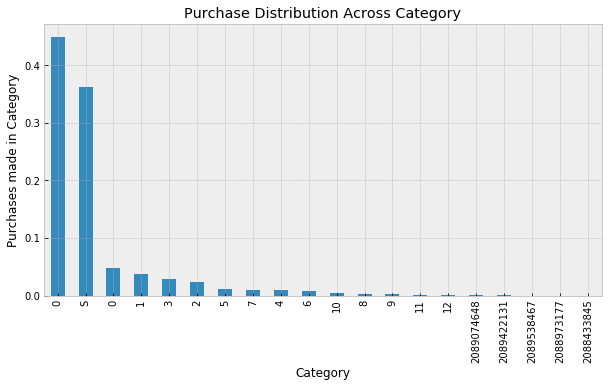

In [9]:
# Distribution of purchases across categories
# All 340 will not fit nicely in a bar chart
# so lets just bar plot the top 20
ax = df_clicks_aug.loc[
    df_clicks_aug['item_purchase'] == 1]['category'] \
    .value_counts(sort=True, normalize=True)[0:20].plot.bar(
        title='Purchase Distribution Across Category')
ax.set_xlabel('Category')
ax.set_ylabel('Purchases made in Category')

This is helpful for continuing to explore the data. One observation is there are four "types" of categories in the data. An integer (i.e., 0), a character ("S"), small integers in str format ("1" - "12") and larger integers in str format:

In [10]:
df_clicks_aug['category'].value_counts().index.values[0:20]

array([0, 'S', '0', '1', '2', '3', '4', '5', '6', '7', '9', '11', '10',
       '8', '12', '2089046251', '2089538467', '2089422131', '2089437536',
       '2089074648'], dtype=object)

Something to keep an eye on. 

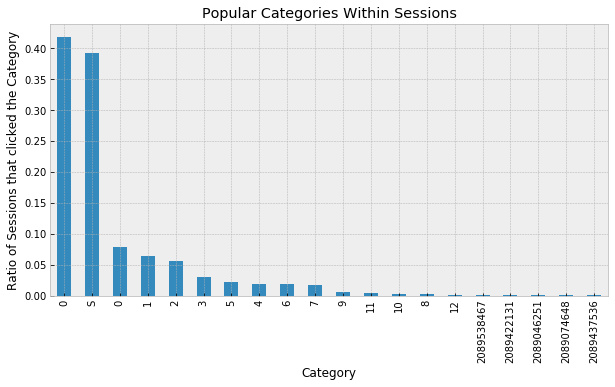

In [11]:
# bar plot
# count unique sessionIDs by category
# normalize to count of all sessionIDs
ax2 = (1.0 * df_clicks_aug
               .groupby('category')
               .sessionID.nunique() / 
         len(df_clicks_aug['sessionID'].unique())) \
               .sort_values(ascending=False)[0:20] \
               .plot.bar(title='Popular Categories Within Sessions')
ax2.set_xlabel('Category')
ax2.set_ylabel('Ratio of Sessions that clicked the Category')

Thinking ahead -- at first glance it looks like the popular categories in sessions align pretty closely to the categories where purchases, i.e., this view of the data may not be all that informative for predicting purchases. 

I think the next question is interesting and will help us to transition to feature engineering. Lets look at category activity relative to purchase activity

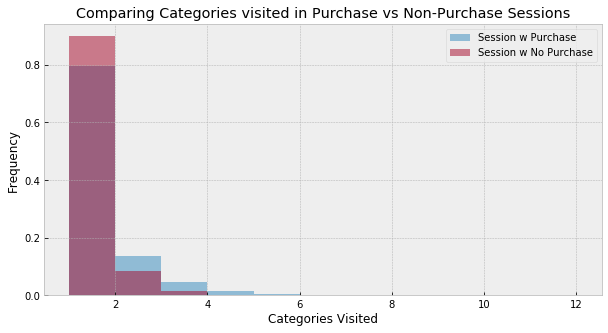

In [12]:
# Compare category activity in a 
# session with a purchase 
# vs 
# session without a purchase
df_clicks_aug \
    .loc[df_clicks_aug['session_purchase'] == 1] \
    .groupby('sessionID') \
    .category.nunique() \
    .plot.hist(alpha=0.5, bins=np.arange(1, 13), normed=True)
ax3 = df_clicks_aug \
    .loc[df_clicks_aug['session_purchase'] == 0] \
    .groupby('sessionID') \
    .category.nunique() \
    .plot.hist(alpha=0.5, bins=np.arange(1, 13), normed=True)
ax3.set_title('Comparing Categories visited in Purchase vs Non-Purchase Sessions')
ax3.set_xlabel('Categories Visited')
ax3.legend(['Session w Purchase', 'Session w No Purchase'])

The histogram highlights that sessions with multiple categories visited are more likely to involve a purchase. Circling back to the original question -- although it's not a silver bullet it does imply category activity does seem to matter and we can use it in our classifier.

We can start shift to feature design, although there is still plenty to learn about the data.

## Step 2: Design Features
Based on the histogram above it looks like categories visited in session might be a feature. We can add that attribute to the clicks dataframe

In [13]:
# add categories visited count as a feature
df_clicks_aug = df_clicks_aug.join(
    other=df_clicks_aug.groupby('sessionID').category.nunique(),
    on='sessionID',
    how='inner',
    lsuffix='_name',
    rsuffix='_visitct')

In [14]:
df_clicks_aug.head()

,sessionID,timestamp,itemID,category_name,session_purchase,price,quantity,item_purchase,category_visitct
41,14,2014-04-01T10:09:01.362Z,214577732,0,0,0.0,0.0,0.0,1
42,14,2014-04-01T10:11:14.773Z,214587013,0,0,0.0,0.0,0.0,1
43,14,2014-04-01T10:12:36.482Z,214577732,0,0,0.0,0.0,0.0,1
46,16,2014-04-05T13:08:01.626Z,214684093,0,0,0.0,0.0,0.0,1
47,16,2014-04-05T13:08:39.897Z,214684093,0,0,0.0,0.0,0.0,1


Similar to categories, individual items may also be more / less likely to be purchased.

In [15]:
print 'There are %i unique items' % len(df_clicks_aug['itemID'].unique())

There are 35694 unique items


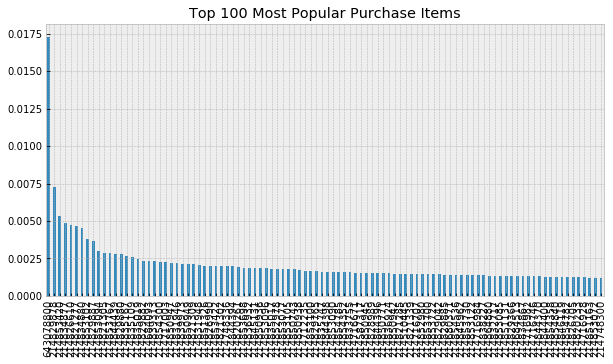

In [16]:
# Distribution of the Top 100 items purchased
df_clicks_aug.loc[
    df_clicks_aug['item_purchase'] == 1]['itemID'] \
    .value_counts(normalize=True)[0:100].plot.bar(title='Top 100 Most Popular Purchase Items')

The distribution appears much longer tailed than the one we drew for categories.

Are some items more likely to purchases vs browses?

In [17]:
# Aggregate over items and count by purchase
purchase_cts = df_clicks_aug.groupby(['itemID', 'item_purchase']).agg('count')['price']
purchase_cts.head()

itemID     item_purchase
214507224  0.0                 1
214507331  0.0              1512
           1.0                37
214507365  0.0               159
           1.0                11
Name: price, dtype: int64

In [18]:
# Calculate buy rate for each item
# There is probably a slicker way to do
# this but we can exert more control
# with our own loop

# loop over items
buy_rates = []
for idx in purchase_cts.index.get_level_values(0).unique():

    # get all clicks on item
    # segmented by purchase event
    clicks = purchase_cts.iloc[
                    purchase_cts
                    .index.get_level_values('itemID') == idx].values

    # only compute a buy rate
    # if we have at least 30
    # clicks
    if np.sum(clicks) > 30:
        if len(clicks) == 2:
            # buy rate
            buy_rate = 1.0 * clicks[1] / (clicks[0] + clicks[1])
        else:
            # no purchases so buy_rate is 0
            buy_rate = 0
    else:
        # not enough data
        # to make a call
        buy_rate = np.nan
    buy_rates.append((idx, buy_rate))

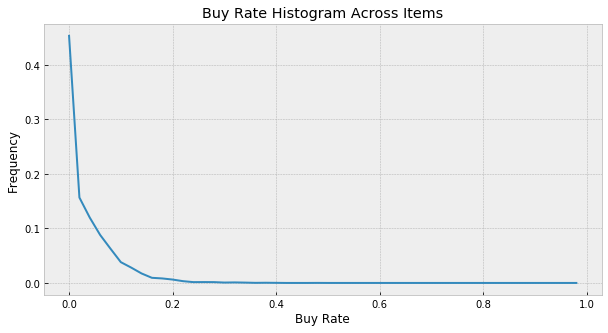

In [19]:
# plot histogram of buy rates
h, be = np.histogram(
            [b[1] for b in buy_rates if not np.isnan(b[1])],
            bins=np.arange(0,1.02, 0.02))
plt.plot(be[:-1], 1.0 * h / np.sum(h))
plt.xlabel('Buy Rate')
plt.ylabel('Frequency')
plt.title('Buy Rate Histogram Across Items')

In [20]:
# join the buy rate onto
# our primary dataframe
df_clicks_aug = pd.merge(
    left=df_clicks_aug,
    right=pd.DataFrame(data=buy_rates, columns=(('itemID', 'buy_rate'))),
    how='left',
    left_on='itemID',
    right_on='itemID')

In [21]:
df_clicks_aug.head()

,sessionID,timestamp,itemID,category_name,session_purchase,price,quantity,item_purchase,category_visitct,buy_rate
0,14,2014-04-01T10:09:01.362Z,214577732,0,0,0.0,0.0,0.0,1,0.024876
1,14,2014-04-01T10:11:14.773Z,214587013,0,0,0.0,0.0,0.0,1,0.000000
2,14,2014-04-01T10:12:36.482Z,214577732,0,0,0.0,0.0,0.0,1,0.024876
3,16,2014-04-05T13:08:01.626Z,214684093,0,0,0.0,0.0,0.0,1,0.079549
4,16,2014-04-05T13:08:39.897Z,214684093,0,0,0.0,0.0,0.0,1,0.079549


Another potential feature could be one purchase leading to another in a session, that is $$P(B[x_i] \mid B[x_k]) $$
where $B[x]$ is a purchase of item $x$. One example of this could buying batteries in the same session as an electronic toy. We can visualize the data by creating an $n \times n$ array of the conditional purchases

This is going to be a beast of a calculation on items, so start on categories

In [22]:
# categories that were purchased
cat_purchases = df_clicks_aug.loc[
                    df_clicks_aug['item_purchase'] == 1] \
                 ['category_name'].unique()

# loop over categories
# store sessionID if
#   a. item was purchased
#   b. category match
# Compare with all sessions
# that saw a click with that category
cat_sessions_dict = {}
cat_all_sessions_dict = {}
for ii, cat in enumerate(cat_purchases):

    # sessions with a purchase of this category
    cat_sessions_dict[cat] = df_clicks_aug.loc[
                            df_clicks_aug['item_purchase'] == 1].loc[
                            df_clicks_aug['category_name'] == cat]['sessionID'].unique()

    # all sessions with this category
    cat_all_sessions_dict[cat] = df_clicks_aug.loc[
                            df_clicks_aug['category_name'] == cat]['sessionID'].unique()
    if ii % 100 == 0:
        print 'Through %i' % ii

Through 0


In [23]:
# Move data into 2D array
# First map category label
# to array index
cat_idx_lookup = {}
unique_cats = df_clicks_aug['category_name'].unique()

for ii, k in enumerate(unique_cats):
    cat_idx_lookup[k] = ii

# initialize 2D array
coloc_cat = np.zeros([len(unique_cats), len(unique_cats)])

# Double loop :(
# TODO - Improve performance
for k1 in cat_purchases:
    for k2 in cat_purchases:

        # Dont store diagonal
        if k1 != k2:
            # array[i, j] = # sessions where cat i purchased /
            # sessions colocated between i and j in the same session
            numer = len(set(cat_sessions_dict[k1]).intersection(
                    set(cat_sessions_dict[k2])))
            denom = len(set(cat_all_sessions_dict[k1]).intersection(
                    set(cat_all_sessions_dict[k2])))
            if denom > 0:
                coloc_cat[cat_idx_lookup[k1], cat_idx_lookup[k2]] = 1.0 * numer / denom
            else:
                coloc_cat[cat_idx_lookup[k1], cat_idx_lookup[k2]] = 0.0

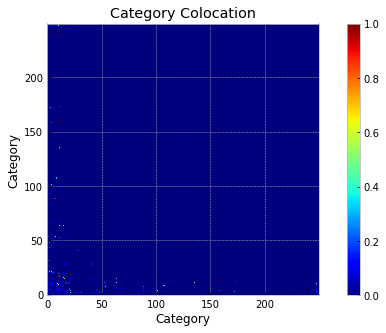

In [24]:
# plot the colocation matrix
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(coloc_cat), cmap=plt.cm.jet, 
                interpolation='nearest', origin='lower')
cb = fig.colorbar(res)
ax.set_title('Category Colocation')
ax.set_xlabel('Category')
ax.set_ylabel('Category')

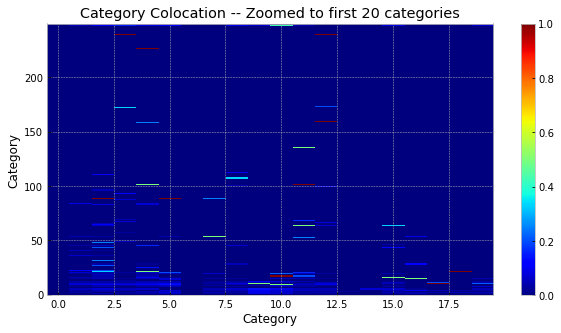

In [25]:
# plot the colocation matrix
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(coloc_cat[:, 0:20]), cmap=plt.cm.jet, 
                interpolation='nearest', origin='lower', aspect='auto')
cb = fig.colorbar(res)
ax.set_title('Category Colocation -- Zoomed to first 20 categories')
ax.set_xlabel('Category')
ax.set_ylabel('Category')

So it is sparse but there is categories that colocate in sales. We can add this feature to our data. The value calculated above will not be helpful for our eventual classifier as it only demonstrates that some correlation does exist between categories within sales sessions. 

Instead we'll need an indicator variable -- that is, for the category in each row we'll have an indicator that flags if that category is also in the session. The classifier should then find the correlations, i.e., if a item in category $x$ is under evaluation then we will give it the feature that category $y$ was also in the session

In [26]:
sessions = df_clicks.sessionID.unique()
session_ct = len(sessions)
session_idx_lookup = pd.Series(data=sessions, index=np.arange(session_ct))

category_indicators = np.zeros([session_ct, len(unique_cats)])
new_col_names = []
for ii, cat in enumerate(unique_cats):
    cat_sessions = df_clicks_aug.loc[df_clicks_aug['category_name'] == cat]['sessionID'].unique()
    idxs = session_idx_lookup[session_idx_lookup.isin(cat_sessions)].index.values
    category_indicators[idxs, ii] = 1

    try:
        col_name = cat + '_coloc'
        new_col_names.append(col_name)
    except TypeError:
        col_name = str(cat) + 's_coloc'
        new_col_names.append(col_name)

df_colocs = pd.DataFrame(data=category_indicators, index=sessions, columns = [new_col_names])
df_colocs.head()

,0s_coloc,0_coloc,S_coloc,2_coloc,1_coloc,3_coloc,2089286907_coloc,9_coloc,6_coloc,10_coloc,...,2088893676_coloc,2089436882_coloc,193468660_coloc,2088954948_coloc,2089421636_coloc,2089314197_coloc,2089425918_coloc,8_coloc,2089039830_coloc,2089573539_coloc
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# join on the co-basket features
df_clicks_aug = df_clicks_aug.join(
                df_colocs,
                on='category_name',
                how='left')

It would be great to do this for items too, but my laptop doesn't seem up to the challenge (TODO look at colocations of items). 

Moving on, there's another question that we'll use to create another feature:
> Is the timestamp important? If so, how?

Let's create two features from timestamp. The first will be session duration and the second will flag sessions that took place on the weekend.

It would be great to create a flag to determine if the session took place during work hours, evening or late night -- however since timestamp is Zulu time that local information is not present.

In [28]:
# convert timestamp to datetime
# to enable feature generation
def convert_to_datetime(dt):
    return datetime.strptime(dt, '%Y-%m-%dT%H:%M:%S.%fZ')

df_clicks_aug['timestamp_datetime'] = df_clicks_aug['timestamp'].apply(convert_to_datetime)

In [29]:
# use newly created datetime field to measure session length
unique_sessions = df_clicks_aug['sessionID'].unique()
session_durs = []
for sessionID in unique_sessions:
    clicks = df_clicks_aug.loc[df_clicks_aug['sessionID'] == sessionID]
    duration = (clicks['timestamp_datetime'].max() - 
                clicks['timestamp_datetime'].min()).seconds
    session_durs.append((sessionID, duration))

In [30]:
# That was a long calculation
# so lets save off the data in case we need it
df_session_durs = pd.DataFrame(data=session_durs, columns=(('sessionID', 'duration_secs')))
df_session_durs.to_csv('df_session_durs.csv')

In [31]:
# merge session durations onto our dataset
df_clicks_aug = pd.merge(left=df_clicks_aug,
                right=df_session_durs,
                left_on = 'sessionID',
                right_on = 'sessionID',
                how = 'left')

In [32]:
# create indicator if its a weekend session
def is_it_weekend(timestamp_datetime):
    """
    flag timestamp if it's 
    weekend --> 1
    or 
    weekeday --> 0
    """
    if timestamp_datetime.weekday() >= 5:
        return 1
    else:
        return 0

df_clicks_aug['weekend_flag'] = df_clicks_aug['timestamp_datetime'].apply(is_it_weekend)

To recap, we have created / identified the following features:
- how many categories were visited in the session
- buy rate for the item under click
- buy rate co-location 
- session duration (seconds)
- did click take place on weekday/weekend

Let's add the buy rate for the category and then move on to the prediction model

In [33]:
# Aggregate over items and count by purchase
cat_purchase_cts = df_clicks_aug.groupby(['category_name', 'item_purchase']).agg('count')['price']

# Calculate buy rate for each category
# There is probably a slicker way to do
# this but we can exert more control
# with our own loop

# loop over items
cat_buy_rates = []
for idx in cat_purchase_cts.index.get_level_values(0).unique():

    # get all clicks on item
    # segmented by purchase event
    clicks = cat_purchase_cts.iloc[
                    cat_purchase_cts
                    .index.get_level_values('category_name') == idx].values

    # only compute a buy rate
    # if we have at least 30
    # clicks
    if np.sum(clicks) > 30:
        if len(clicks) == 2:
            # buy rate
            cat_buy_rate = 1.0 * clicks[1] / (clicks[0] + clicks[1])
        else:
            # no purchases so buy_rate is 0
            cat_buy_rate = 0
    else:
        # not enough data
        # to make a call
        cat_buy_rate = np.nan
    cat_buy_rates.append((idx, cat_buy_rate))

# join the cat_buy rate onto
# our primary dataframe
df_clicks_aug = pd.merge(
    left=df_clicks_aug,
    right=pd.DataFrame(data=cat_buy_rates, columns=(('category_name', 'cat_buy_rate'))),
    how='left',
    left_on='category_name',
    right_on='category_name')

In [34]:
# Save data
df_clicks_aug.to_csv('df_clicks_aug.csv')

### 3. Prediction

Per our instructions:
> Using any approach you like, and any library you like, build a model to predict whether a user will buy a product based on session activity. Don’t worry too much about accuracy or performance; imagine we want to build a baseline that we can improve upon over time.

I'm going to build a classifier using sklearn technology. Specifically, we'll
- set up a KFold cross validator with the sklearn KFold module
- create a classification pipeline with sklearn Pipeline
     - Pipeline allows us to build classifier object with pre-processsing steps as well as classification algorithm
     - If needed we can expand to additional features



To start, we'll use a logistic regression classifier. I chose this engine for several reasons:
1. Our labels are binary (i.e., purchase or not purchase)
2. We have binary, discrete and continuous variables
3. I have been using this algorithm lately and have some comfort with it.

That said, a big TODO would be to try some of the other approaches (random forest in particular seems like it could work well in this space)

In [35]:
df_clicks_aug.head()

,sessionID,timestamp,itemID,category_name,session_purchase,price,quantity,item_purchase,category_visitct,buy_rate,...,2089421636_coloc,2089314197_coloc,2089425918_coloc,8_coloc,2089039830_coloc,2089573539_coloc,timestamp_datetime,duration_secs,weekend_flag,cat_buy_rate
0,14,2014-04-01T10:09:01.362Z,214577732,0,0,0.0,0.0,0.0,1,0.024876,...,NaN,NaN,NaN,NaN,NaN,NaN,2014-04-01 10:09:01.362,215,0,0.057289
1,14,2014-04-01T10:11:14.773Z,214587013,0,0,0.0,0.0,0.0,1,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2014-04-01 10:11:14.773,215,0,0.057289
2,14,2014-04-01T10:12:36.482Z,214577732,0,0,0.0,0.0,0.0,1,0.024876,...,NaN,NaN,NaN,NaN,NaN,NaN,2014-04-01 10:12:36.482,215,0,0.057289
3,16,2014-04-05T13:08:01.626Z,214684093,0,0,0.0,0.0,0.0,1,0.079549,...,NaN,NaN,NaN,NaN,NaN,NaN,2014-04-05 13:08:01.626,771,1,0.057289
4,16,2014-04-05T13:08:39.897Z,214684093,0,0,0.0,0.0,0.0,1,0.079549,...,NaN,NaN,NaN,NaN,NaN,NaN,2014-04-05 13:08:39.897,771,1,0.057289


In [36]:
# Create feature and label arrays
not_features = ['sessionID', 'timestamp', 
                'itemID', 'category_name',
                'session_purchase', 'price',
                'quantity', 'item_purchase', 'timestamp_datetime']
feature_columns = [c for c in df_clicks_aug.columns if c not in not_features]
X_ = df_clicks_aug[feature_columns]
Y_ = df_clicks_aug['item_purchase']

In [37]:
# sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn.cross_validation import KFold
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import Imputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression

from scipy import interp

/Users/dfinkel/siphonenv/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


through another fold
through another fold
through another fold
through another fold
through another fold
through another fold


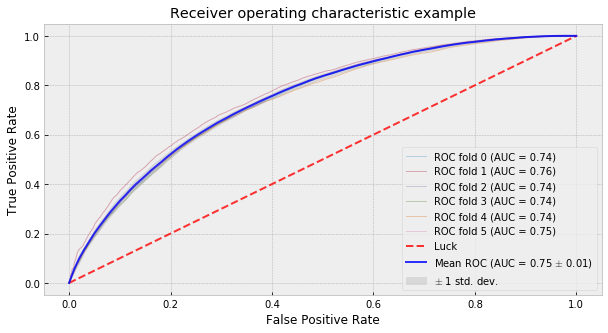

In [38]:
# initialize folds
k_fold = KFold(n=len(df_clicks_aug), n_folds=6)

# initialize classifier
pipeline = Pipeline([
          ("imputer", Imputer(missing_values="NaN", strategy="mean", axis=0)),
          ("classifier", LogisticRegression()),
          ])
          

# initialize results variables
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# loop over folds
ii = 0
for train_indices, test_indices in k_fold:

    # fit pipeline to training data
    pipeline.fit(X_.iloc[train_indices], Y_.iloc[train_indices])
    
    # compute probablilities for test data
    probas_ = pipeline.predict_proba(X_.iloc[test_indices])

    # Compute ROC curve and area under the curve
    test_y = Y_.iloc[test_indices]

    fpr, tpr, thresholds = roc_curve(test_y, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # plot ROC fold results
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (ii, roc_auc))

    ii += 1   
    print 'through another fold'

# plot guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

# plot results
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The last thing to check is a quick search on the penalty term factor, $C$ to see if it's set properly or if a better value for it will yield a better ROC curve.

In [48]:
from sklearn.model_selection import GridSearchCV
# pipeline.get_params().keys()
parameters = {'classifier__C':[1, 10, 20, 30, 40]}
clf = GridSearchCV(pipeline, parameters)
clf.fit(X_, Y_)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__C': [1, 10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

According to the output from the gridsearch leaving $C$ at 1 is appropriate.

There are ten questions included in the instructions:

> Why did you choose the model you did? Can you explain the intuition/motivation behind it?

Repeating from above, my reasoning for this model were:
1. Our labels are binary (i.e., purchase or not purchase)
2. We have binary, discrete and continuous variables
3. I have been using this algorithm lately and have some comfort with it.

Log regression is a linear model. The intuition behind it is a distribution function is fit to the feature space. As in our case when there are a binary labels on the data, the classifier labels predictions onto a distribution curve, i.e., if the features of an item are $r$ and the log-regression weights are $\omega$ then the decision criteria is $F(r, \omega)$ where $F$ is the logit transformation. If $F(r, \omega) > 0.5$ then the first label is applied to the feature set $r$ and the second label if the logit transformation is greater than 0.5 

> What are the specific challenges/benefits associated with the model you chose? How did you choose the model parameters, if applicable?

Benefits of a log regression approach is that it handles categorical independent and dependent variables well. Another benefit is that it is fairly robust for these type of problems (in my experience). A challenge is it's linearity -- there are more degrees of freedome for the classifier with nonlinear approaches like SVM. 

One preprocessing step I needed to add to the model was a cleaner for NaNs in the feature space. The python library sklearn provides a nice function for this that came in handy and I included it in our pipeline.

I rand a gridsearch to tune one parameter of the model (the penalty term $C$ that helps control over-fitting. You can see that code above.

> What sort of data preprocessing did you do, if any, to ensure the model behaved properly?

A significant portion of this notebook is devoted to our preprocessing so I won't rehash that here. The key themes were (a) keeping in mind the linearity assumption of the logit model, (b)converting categorical variables into binaries and (c) using NaNs as needed in the preprocessing and then applying a imputer cleaner in classification pipeline.

> What, if any, other model specific choices did you make to better fit the problem at hand?

One approach that I like to use on problems like this is move as-much-as-possible of the data preparation into the pipeline. That is, create a pipeline that takes in the dataframe, splits the data out into different sets of features, pre-processes them into engineered features then re-combines them before the classification algorithm does its magic. My model never grew enough in sophistication to warrant using feature union for this problem.

> How did you evaluate the model?

I decided to use a ROC curve evaluation of the features and model using 6 folds of the data. I think this is a good approach when exploring a problem and trying to understand baseline performance. The ROC curves for all 6 folds were plotted above along with the mean curve and it's AUC. 

> How can we improve the model? Do we need more data? If so, what type? More features? Would you ask the business for additional fields in the data? If so, what would you ask for?

Great question. I'm sure a search across more of the parameter space of the model would yield some improvements in the performance and absolutely should be done. For this exercise I did a search across different penalty terms, $C$, for log regression. However, it was not a complete search.

Another opportunity to improve performance would be swap in some different models (SVM, random forest, a CNN, etc...) and see if they can infer information from the data better. For example, maybe the linearity assumption is a bad one, e.g., perhaps really short duration sessions are low probability buys, mid-length sessions are high probability purchase situations and long sessions are low probability.

More data would be great! One piece of information I would ask for would be longitudinal data on the individual. That is, adding a field such as "userID" and then tracking that user across sessions. I imagine that would be very informative -- i.e., there are probably "tells" that different shoppers have that indicate if they are serious about making a purchase. Another nice-to-have field would be indicators of on-page behavior. For example, did they read the product-reviews? Another nice piece of data would be to understand where in the purchase journey an individual made it. i.e., did he/she place the item in their basket or just look at the splash page. Yet another piece of data that would be great would be referral approach, i.e., how did the user end up on this item page? Was it via search or an ad/referral on another item page?

> Based on the task objective, which error do you think we should minimize – incorrectly identifying a user as a buyer, or missing a buyer?

Hmm...in times past this question has had an obvious answer. For example, when working on defense related problems false alarms were much more tolerable than leakers. Likewise, when working on client-facing projects, false alarms created mistrust of the data within users and it was better to err on the side of missed detections.

Ultimately I think it depends on the application of the data. For personalization purposes I it might be better to miss buyers than label non-purchases as purchases. That is, the frustration experienced by a user who was incorrectly identified as a buyer might drive that customer away from your site and cause them to lose confidence in your e-commerce. In the long run, that might cost you more than whatever benefits you were trying to convey to the buyer you missed.

However, if the application of this prediction is, say scheduling CPU resources for checkout -- then maybe you want to err on the side of allowing more false alarms. A buyer who experiences a laggy checkout process might get frustrated and not come back. You may want to avoid those at all costs.

> Based on your answer above, how might you/did you adjust your approach?

Since we presented our result as a ROC curve it doesn't change too much from above. Our answer above would impact where on the ROC curve we chose our design point for the classifier. 

> How easy would it be to generalize your approach to other sites? What factors would we need to consider before implementing this approach at scale in a production environment?

First, we should get it out of a Jupyter notebook! To apply to scale a few thoughts come to mind:
    1. Move the data to databases instead of flat files
    2. Implement the feature production in something like Spark
    3. Continue to build out and experiment with different features sets
    4. Store the classifier inputs (i.e., weights) and use them in a production chain.

> Imagine we’ve improved our model to the point where we can perfectly predict whether a user will buy an item. What should be done with this information? How should we apply it, to best help our business and help users on our site?

After reading this question I thought about how a grocery store exploits the fact that placing an item in your cart is a (near) perfect indicator of purchase intent. From this analogy a few strategies jump out to me:

1. Allocate checkout resources to make sure these shoppers who intend to purchase have 5-start checkout experiences. Someone who purchases from you has the potential to become a loyal customer -- you want to maximize this potential by streamlining their checkout and making sure it is a fast and seamless process. Just like a grocery store customers might get frustrated with slow checkout processes. The lead time in knowing a purchase is about to occur could be used to direct server resources toward that checkout. You may also want to position the "buy" button in a high real-estate location as well and make it easy for the person to buy

2. The up-sell ads could also change based on purchase intent. If someone is about to purchase an item then you could/would want to show them ads/recommendations for products that accompany that purchase. Likewise if someone is browsing then you would want to design your recommendation strategy differently.

3. If my commerce site operated in a short-term delivery paradigm (1 hour delivery for example), or if key delivery deadlines were approaching (orders made after 5pm cost my business more in shipping) I would certainly take advantage of the time savings inherent in instant awareness of a product sales and begin the delivery process.

4. I think you could use this information to improve the performance of recommendation engines used by the commerce site. I believe the conditional knowledge known by the scenario (purchase intent given click) could be exploited by the recommendation engine to optimize recommendations shown to a user on the splash page. The optimal strategy for such a display would be interesting (grocery store don't always place high purchase intent items in optimal locations) but I think it could improve performance.

Thanks!
-Dan

March 30 2018

### BACK-UP

In [49]:
# Code I considered using
# more streamlined pipeline


# # Data extraction class
# class FeaturesExtractor(BaseEstimator, TransformerMixin):
#     """
#     Custom Helper class for pipeline
#     Extract the category labels, and the derived features from our dataframe

#     Takes a sequence of strings and produces a dict of sequences.
#     Keys are
#         - 'category'
#         - 'derived_features'
#     """
#     def fit(self, x, y=None):
#         # no-op function
#         return self

#     def transform(self, df_data):
#         # initialize output for transform
#         features = np.recarray(shape=(len(df_data),),
#                                dtype=[('category', object),
#                                       ('derived_features', object)])

#         # get derived feature column names
#         not_features = ['sessionID', 'timestamp', 
#                     'itemID', 'category_name',
#                     'session_purchase', 'price',
#                     'quantity', 'item_purchase', 'timestamp_datetime']
#         derived_feature_columns = [c for c in df_data.columns if c not in not_features]

#         # extract features from dataframe
#         for i, row in enumerate(df_data.iterrows()):
#             features['category'][i] = row[1]['category_name']
            
#             X_ = row[1][derived_feature_columns].values
#             derived_feature_dict = {derived_feature_columns[ii]:X_[ii] 
#                                         for ii in np.arange(len(X_))}
#             features['derived_features'][i] = derived_feature_dict
#         return features
    
# # Pipeline class that selects data
# class ItemSelector(BaseEstimator, TransformerMixin):
#     """
#     For data grouped by feature, select subset of data at a provided key.

#     The data is expected to be stored in a 2D data structure, where the first
#     index is over features and the second is over samples.  i.e.

#     >> len(data[key]) == n_samples

#     Please note that this is the opposite convention to scikit-learn feature
#     matrixes (where the first index corresponds to sample).

#     ItemSelector only requires that the collection implement getitem
#     (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
#     DataFrame, numpy record array, etc.

#     >> data = {'a': [1, 5, 2, 5, 2, 8],
#                'b': [9, 4, 1, 4, 1, 3]}
#     >> ds = ItemSelector(key='a')
#     >> data['a'] == ds.transform(data)

#     ItemSelector is not designed to handle data grouped by sample.  (e.g. a
#     list of dicts).  If your data is structured this way, consider a
#     transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

#     Parameters
#     ----------
#     key : hashable, required
#         The key corresponding to the desired value in a mappable.
#     """
#     def __init__(self, key):
#         self.key = key

#     def fit(self, x, y=None):
#         return self

#     def transform(self, data_dict):
#         return data_dict[self.key]

In [41]:
# # Construct Pipeline
# pipeline = Pipeline([
#     # Extract survey scores, behavior data and text
#     ('features', FeaturesExtractor()),

#     # Use FeatureUnion to combine the features from subject and body
#     ('union', FeatureUnion(
#         transformer_list=[

#             # Pipeline for pulling derived_features
#             ('derived_features', Pipeline([
#                 ('selector', ItemSelector(key='derived_features')),
#                 ('vect', DictVectorizer()),
#                 ("imputer", Imputer(missing_values="NaN",
#                                           strategy="mean",
#                                           axis=0)),                                   
#             ])),

#             # Pipeline for standard bag-of-words model for body
#             ('category', Pipeline([
#                 ('selector', ItemSelector(key='category')),
#                 ('vect', CountVectorizer()),
#             ])),
#         ],
#     )),

#     # Use a log regression classifier on the combined features
#     ('classifier', LogisticRegression()),
# ])